<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [2]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Numerical Differentiation

**GOAL:**  Given a set of $N+1$ points $(x_i, y_i)$ compute the derivative of a given order to a specified accuracy.

**Approach:** Find the interpolating polynomial $P_N(x)$ and differentiate that.

### Newton's Form

For ease of analysis we will write $P_N(x)$ in Newton's form which looks like

$$P_N(x) = \sum^N_{j=0} a_j n_j(x)$$

where 

$$n_j(x) = \prod^{j-1}_{i=0} (x - x_i)$$

and the $a_j = [y_0, \ldots, y_j]$ are the divided differences defined in general as

$$[y_i] = y_i ~~~~~ i \in \{0,\ldots, N+1\}$$

and

$$[y_i, \ldots , y_{i+j}] = \frac{[y_{i+1}, \ldots , y_{i + j}] - [y_{i},\ldots,y_{i+j-1}]}{x_{i+j} - x_{i}} ~~~~~ i \in \{0,\ldots,N+1 - j\} ~~~~ j \in \{1,\ldots, N+1\}$$

These formulas are recursively defined but not so helpful, here are a few examples to start out with:

$$[y_0] = y_0$$

$$[y_0, y_1] = \frac{y_1 - y_0}{x_1 - x_0}$$

$$[y_0, y_1, y_2] = \frac{[y_1, y_2] - [y_0, y_1]}{x_{2} - x_{0}} = \frac{\frac{y_2 - y_1}{x_2 - x_1} - \frac{y_1 - y_0}{x_1 - x_0}}{x_2 - x_0} = \frac{y_2 - y_1}{(x_2 - x_1)(x_2 - x_0)} - \frac{y_1 - y_0}{(x_1 - x_0)(x_2 - x_0)}$$

The benefit of writing a polynomial like this is that it isolates the $x$ dependence (we can easily take derivatives of this form).

In general then $P_N(x)$ can be written in Newton's form as

$$P_N(x) = y_0 + (x-x_0)[y_0, y_1] + (x - x_0) (x - x_1) [y_0, y_1, y_2] + \cdots + (x-x_0) (x-x_1) \cdots (x-x_{N-1}) [y_0, y_1, \ldots, y_{N}]$$

As another concrete example consider and quadratic polynomial written in Newton's form

$$P_2(x) = [y_0] + (x - x_0) [y_0, y_1] + (x - x_0)(x - x_1) [y_0, y_1, y_2] \\= y_0 + (x - x_0) \frac{y_1 - y_0}{x_1 - x_0} + (x - x_0)(x - x_1) \left ( \frac{y_2 - y_1}{(x_2 - x_1)(x_2 - x_0)} - \frac{y_1 - y_0}{(x_1 - x_0)(x_2 - x_0)} \right )$$

Recall that the interpolating polynomial of degree $N$ through these points is unique!

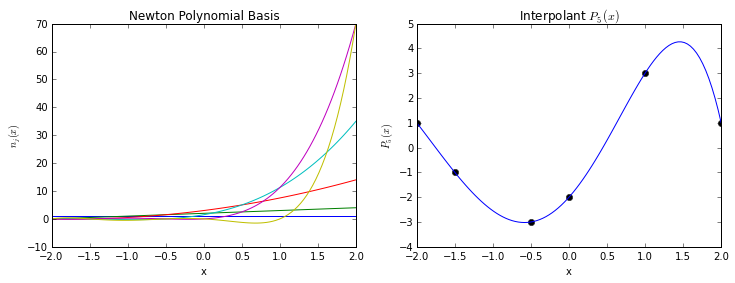

In [3]:
def divided_difference(x, y, N=50):
#     print x.shape, N
    if N == 0:
        raise Exception("Reached recurssion limit!")
    
    # Reached the end of the recurssion
    if y.shape[0] == 1:
        return y[0]
    elif y.shape[0] == 2:
        return (y[1] - y[0]) / (x[1] - x[0])
    else:
        return (divided_difference(x[1:], y[1:], N=N-1) - divided_difference(x[:-1], y[:-1], N=N-1)) / (x[-1] - x[0])

    
# Calculate a polynomial in Newton Form
data = numpy.array([[-2.0, 1.0], [-1.5, -1.0], [-0.5, -3.0], [0.0, -2.0], [1.0, 3.0], [2.0, 1.0]])
N = data.shape[0] - 1
x = numpy.linspace(-2.0, 2.0, 100)

# Construct basis functions
newton_basis = numpy.ones((N + 1, x.shape[0]))
for j in xrange(N + 1):
    for i in xrange(j):
        newton_basis[j, :] *= (x - data[i, 0])

# Construct full polynomial
P = numpy.zeros(x.shape)
for j in xrange(N + 1):
    P += divided_difference(data[:j + 1, 0], data[:j + 1, 1]) * newton_basis[j, :]
    
# Plot basis and interpolant
fig = plt.figure()
fig.set_figwidth(2.0 * fig.get_figwidth())
axes = [None, None]
axes[0] = fig.add_subplot(1, 2, 1)
axes[1] = fig.add_subplot(1, 2, 2)

for j in xrange(N + 1):
    axes[0].plot(x, newton_basis[j, :])
    axes[1].plot(data[j, 0], data[j, 1],'ko')
axes[1].plot(x, P)

axes[0].set_title("Newton Polynomial Basis")
axes[0].set_xlabel("x")
axes[0].set_ylabel("$n_j(x)$")

axes[1].set_title("Interpolant $P_%s(x)$" % N)
axes[1].set_xlabel("x")
axes[1].set_ylabel("$P_%s(x)$" % N)

plt.show()

### Error Analysis

Given $N + 1$ points we can form an interpolant $P_N(x)$ of degree $N$ where

$$f(x) = P_N(x) + R_N(x)$$

We know from Lagrange's Theorem that the remainder term looks like

$$R_N(x) = (x - x_0)(x - x_1)\cdots (x - x_{N})(x - x_{N+1}) \frac{f^{(N+1)}(c)}{(N+1)!}$$

noting that we need to require that $f(x) \in C^{N+1}$ on the interval of interest.  Taking the derivative of the interpolant $P_N(x)$ then leads to 

$$P_N'(x) = [y_0, y_1] + ((x - x_1) + (x - x_0)) [y_0, y_1, y_2] + \cdots + \left(\sum^{N-1}_{i=0}\left( \prod^{N-1}_{j=0,~j\neq i} (x - x_j) \right )\right ) [y_0, y_1, \ldots, y_N]$$

Similarly we can find the derivative of the remainder term $R_N(x)$ as

$$R_N'(x) = \left(\sum^{N}_{i=0} \left( \prod^{N}_{j=0,~j\neq i} (x - x_j) \right )\right ) \frac{f^{(N+1)}(c)}{(N+1)!}$$

Now if we consider the approximation of the derivative evaluated at one of our data points $(x_k, y_k)$ these expressions simplify such that

$$f'(x_k) = P_N'(x_k) + R_N'(x_k)$$

If we let $\Delta x = \max_i |x_k - x_i|$ we then know that the remainder term will be $\mathcal{O}(\Delta x^N)$ as $\Delta x \rightarrow 0$ thus showing that this approach converges and we can find arbitrarily high order approximations.

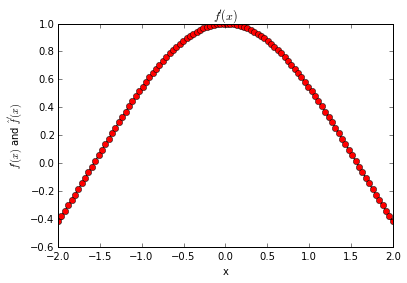

In [4]:
# Compute the approximation to the derivative
# data = numpy.array([[-2.0, 1.0], [-1.5, -1.0], [-0.5, -3.0], [0.0, -2.0], [1.0, 3.0], [2.0, 1.0]])
num_points = 15
data = numpy.empty((num_points, 2))
data[:, 0] = numpy.linspace(-2.0, 2.0, num_points)
data[:, 1] = numpy.sin(data[:, 0])
N = data.shape[0] - 1
x = numpy.linspace(-2.0, 2.0, 100)

# General form of derivative of P_N'(x)
P_prime = numpy.zeros(x.shape)
newton_basis_prime = numpy.empty(x.shape)
product = numpy.empty(x.shape)
for n in xrange(N):
    newton_basis_prime = 0.0
    for i in xrange(n):
        product = 1.0
        for j in xrange(n):
            if j != i:
                product *= (x - data[j, 0])
        newton_basis_prime += product
    P_prime += divided_difference(data[:n+1, 0], data[:n+1, 1]) * newton_basis_prime
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, numpy.cos(x), 'k')
axes.plot(x, P_prime, 'ro')

axes.set_title("$f'(x)$")
axes.set_xlabel("x")
axes.set_ylabel("$f'(x)$ and $\hat{f}'(x)$")

plt.show()

## Examples

Often in practice we only use a small number of data points to derive a differentiation formula.  In the context of differential equations we also often have $f(x)$ so that $f(x_k) = y_k$ and we can approximate the derivative of a known function $f(x)$.

### Example 1:  1st order Forward and Backward Differences

Using 2 points we can get an approximation that is $\mathcal{O}(\Delta x)$:

$$f'(x) \approx P_1'(x) = [y_0, y_1] = \frac{y_1 - y_0}{x_1 - x_0} = \frac{y_1 - y_0}{\Delta x} = \frac{f(x_1) - f(x_0)}{\Delta x}$$

We can also calculate the error as

$$R_1'(x) = -\Delta x \frac{f''(c)}{2}$$

We can also derive the "forward" and "backward" formulas by considering the question slightly differently.  Say we want $f'(x_n)$, then the "forward" finite-difference can be written as

$$f'(x_n) \approx D_1^+ = \frac{f(x_{n+1}) - f(x_n)}{\Delta x}$$

and the "backward" finite-difference as

$$f'(x_n) \approx D_1^- = \frac{f(x_n) - f(x_{n-1})}{\Delta x}$$

Note these approximations should be familiar to use as the limit as $\Delta x \rightarrow 0$ these are no longer approximations but equivalent definitions of the derivative at $x_n$.

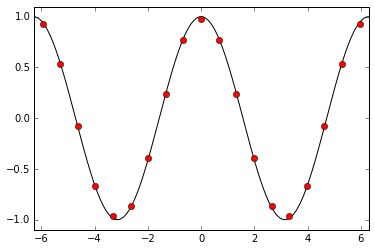

In [5]:
f = lambda x: numpy.sin(x)
f_prime = lambda x: numpy.cos(x)

# Use uniform discretization
x = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, 1000)
N = 20
x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N)
delta_x = x_hat[1] - x_hat[0]

# Compute forward difference using a loop
f_prime_hat = numpy.empty(x_hat.shape)
for i in xrange(N - 1):
    f_prime_hat[i] = (f(x_hat[i+1]) - f(x_hat[i])) / delta_x
f_prime_hat[-1] = (f(x_hat[i]) - f(x_hat[i-1])) / delta_x

# Vector based calculation
# f_prime_hat[:-1] = (f(x_hat[1:]) - f(x_hat[:-1])) / (delta_x)

# Use first-order differences for points at edge of domain
f_prime_hat[-1] = (f(x_hat[-1]) - f(x_hat[-2])) / delta_x  # Backward Difference at x_N

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, f_prime(x), 'k')
axes.plot(x_hat + 0.5 * delta_x, f_prime_hat, 'ro')
axes.set_xlim((x[0], x[-1]))
axes.set_ylim((-1.1, 1.1))

plt.show()

#### Computing Order of Convergence

$$\begin{aligned}
    e(\Delta x) &= C \Delta x^n \\
    \log e(\Delta x) &= \log C + n \log \Delta x
\end{aligned}$$

Slope of line is $n$ when computing this!  We can also match the first point by solving for $C$:

$$C = e^{\log e(\Delta x) - n \log \Delta x}$$

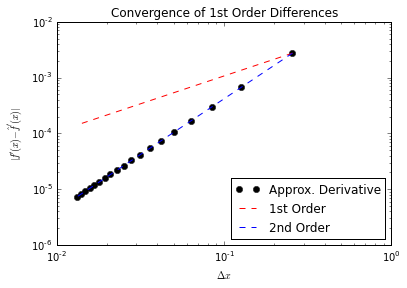

In [15]:
# Compute the error as a function of delta_x
delta_x = []
error = []
# for N in xrange(2, 101):
for N in xrange(50, 1000, 50):
    x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N)
    delta_x.append(x_hat[1] - x_hat[0])

    # Compute forward difference
    f_prime_hat = numpy.empty(x_hat.shape)
    f_prime_hat[:-1] = (f(x_hat[1:]) - f(x_hat[:-1])) / (delta_x[-1])

    # Use first-order differences for points at edge of domain
    f_prime_hat[-1] = (f(x_hat[-1]) - f(x_hat[-2])) / delta_x[-1]  # Backward Difference at x_N
    
    error.append(numpy.linalg.norm(numpy.abs(f_prime(x_hat + 0.5 * delta_x[-1]) - f_prime_hat), ord=numpy.infty))
    
error = numpy.array(error)
delta_x = numpy.array(delta_x)
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_x, error, 'ko', label="Approx. Derivative")

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
axes.legend(loc=4)
axes.set_title("Convergence of 1st Order Differences")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$|f'(x) - \hat{f}'(x)|$")

plt.show()

### Example 2: 2nd Order Centered Difference

Now lets use 3 points to calculate the 2nd order accurate finite-difference.  Consider the points $(x_{n}, y_{n})$, $(x_{n-1}, y_{n-1})$, and $(x_{n+1}, y_{n+1})$, from before we have

$$P_2'(x) = [f(x_n), f(x_{n+1})] + ((x - x_n) + (x - x_{n+1})) [f(x_n), f(x_{n+1}), f(x_{n-1})]$$

$$= \frac{f(x_{n+1}) - f(x_n)}{x_{n+1} - x_n} + ((x - x_n) + (x - x_{n+1})) \left ( \frac{f(x_{n-1}) - f(x_{n+1})}{(x_{n-1} - x_{n+1})(x_{n-1} - x_n)} - \frac{f(x_{n+1}) - f(x_n)}{(x_{n+1} - x_n)(x_{n-1} - x_n)} \right )$$

Evaluating at $x_n$ and assuming the points $x_{n-1}, x_n, x_{n+1}$ are evenly spaced leads to

$$P_2'(x_n) = \frac{f(x_{n+1}) - f(x_n)}{\Delta x} - \Delta x \left ( \frac{f(x_{n-1}) - f(x_{n+1})}{2\Delta x^2} + \frac{f(x_{n+1}) - f(x_n)}{\Delta x^2} \right )$$

$$=\frac{f(x_{n+1}) - f(x_n)}{\Delta x} - \left ( \frac{f(x_{n+1}) - 2f(x_n) + f(x_{n-1})}{2\Delta x}\right )$$

$$=\frac{2f(x_{n+1}) - 2f(x_n) - f(x_{n+1}) + 2f(x_n) - f(x_{n-1})}{2 \Delta x}$$

$$=\frac{f(x_{n+1}) - f(x_{n-1})}{2 \Delta x}$$

This finite-difference is second order accurate and is centered about the point it is meant to approximate ($x_n$).  We can show that it is second order by again considering the remainder term's derivative

$$R_2'(x) = \left(\sum^{2}_{i=0} \left( \prod^{2}_{j=0,~j\neq i} (x - x_j) \right )\right ) \frac{f'''(c)}{3!}$$ 

$$= \left ( (x - x_{n+1}) (x - x_{n-1}) + (x-x_n) (x-x_{n-1}) + (x-x_n)(x-x_{n+1}) \right ) \frac{f'''(c)}{3!}$$

Again evaluating this expression at $x = x_n$ and assuming evenly space points we have

$$R_2'(x_n) = -\Delta x^2 \frac{f'''(c)}{3!}$$

showing that our error is $\mathcal{O}(\Delta x^2)$.

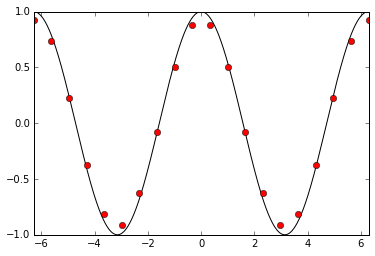

In [7]:
f = lambda x: numpy.sin(x)
f_prime = lambda x: numpy.cos(x)

# Use uniform discretization
x = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, 1000)
N = 20
x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N)
delta_x = x_hat[1] - x_hat[0]

# Compute derivative
f_prime_hat = numpy.empty(x_hat.shape)
f_prime_hat[1:-1] = (f(x_hat[2:]) - f(x_hat[:-2])) / (2 * delta_x)

# Use first-order differences for points at edge of domain
f_prime_hat[0] = (f(x_hat[1]) - f(x_hat[0])) / delta_x     # Forward Difference at x_0
f_prime_hat[-1] = (f(x_hat[-1]) - f(x_hat[-2])) / delta_x  # Backward Difference at x_N
# f_prime_hat[0] = (-3.0 * f(x_hat[0]) + 4.0 * f(x_hat[1]) - f(x_hat[2])) / (2.0 * delta_x)
# f_prime_hat[-1] = (3.0 * f(x_hat[-1]) - 4.0 * f(x_hat[-2]) + f(x_hat[-3])) / (2.0 * delta_x)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, f_prime(x), 'k')
axes.plot(x_hat, f_prime_hat, 'ro')
axes.set_xlim((x[0], x[-1]))
# axes.set_ylim((-1.1, 1.1))

plt.show()

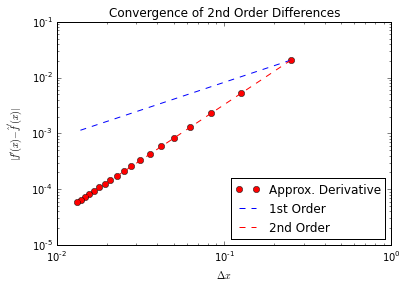

In [14]:
# Compute the error as a function of delta_x
delta_x = []
error = []
# for N in xrange(2, 101):
for N in xrange(50, 1000, 50):
    x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N + 1)
    delta_x.append(x_hat[1] - x_hat[0])

    # Compute derivative
    f_prime_hat = numpy.empty(x_hat.shape)
    f_prime_hat[1:-1] = (f(x_hat[2:]) - f(x_hat[:-2])) / (2 * delta_x[-1])

    # Use first-order differences for points at edge of domain
#     f_prime_hat[0] = (f(x_hat[1]) - f(x_hat[0])) / delta_x[-1]  
#     f_prime_hat[-1] = (f(x_hat[-1]) - f(x_hat[-2])) / delta_x[-1]
    # Use second-order differences for points at edge of domain
    f_prime_hat[0] =  (-3.0 * f(x_hat[0])  +  4.0 * f(x_hat[1])  + - f(x_hat[2]))  / (2.0 * delta_x[-1])
    f_prime_hat[-1] = ( 3.0 * f(x_hat[-1]) + -4.0 * f(x_hat[-2]) +   f(x_hat[-3])) / (2.0 * delta_x[-1])
    
    error.append(numpy.linalg.norm(numpy.abs(f_prime(x_hat) - f_prime_hat), ord=numpy.infty))
    
error = numpy.array(error)
delta_x = numpy.array(delta_x)
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_x, error, "ro", label="Approx. Derivative")

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'b--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'r--', label="2nd Order")
axes.legend(loc=4)
axes.set_title("Convergence of 2nd Order Differences")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$|f'(x) - \hat{f}'(x)|$")

plt.show()

### Example 3: Alternative Derivations

An alternative method for finding finite-difference formulas is by using Taylor series expansions about the point we want to approximate.  The Taylor series about $x_n$ is

$$f(x) = f(x_n) + (x - x_n) f'(x_n) + \frac{(x - x_n)^2}{2!} f''(x_n) + \frac{(x - x_n)^3}{3!} f'''(x_n) + \mathcal{O}((x - x_n)^4)$$

Say we want to derive the second order accurate, first derivative approximation that just did, this requires the values $(x_{n+1}, f(x_{n+1})$ and $(x_{n-1}, f(x_{n-1})$.  We can express these values via our Taylor series approximation above as

$$f(x_{n+1}) = f(x_n) + (x_{n+1} - x_n) f'(x_n) + \frac{(x_{n+1} - x_n)^2}{2!} f''(x_n) + \frac{(x_{n+1} - x_n)^3}{3!} f'''(x_n) + \mathcal{O}((x_{n+1} - x_n)^4) $$

$$ = f(x_n) + \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) + \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4) $$

and

$$f(x_{n-1}) = f(x_n) + (x_{n-1} - x_n) f'(x_n) + \frac{(x_{n-1} - x_n)^2}{2!} f''(x_n) + \frac{(x_{n-1} - x_n)^3}{3!} f'''(x_n) + \mathcal{O}((x_{n-1} - x_n)^4) $$

$$ = f(x_n) - \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) - \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4) $$

Now to find out how to combine these into an expression for the derivative we assume our approximation looks like

$$f'(x_n) + R(x_n) = A f(x_{n+1}) + B f(x_n) + C f(x_{n-1})$$

where $R(x_n)$ is our error.  Plugging in the Taylor series approximations we find

$$f'(x_n) + R(x_n) = A \left ( f(x_n) + \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) + \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4)\right ) + B f(x_n) + C \left ( f(x_n) - \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) - \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4) \right )$$

Since we want $R(x_n) = \mathcal{O}(\Delta x^2)$ we want all terms lower than this to dissapear except for those multiplying $f'(x_n)$ as those should sum to 1 to give us our approximation.  Collecting the terms with common $\Delta x^n$ we get a series of expressions for the coefficients $A$, $B$, and $C$ based on the fact we want an approximation to $f'(x_n)$.  The $n=0$ terms collected are $A + B + C$ and are set to 0 as we want the $f(x_n)$ term to dissapear

$$\Delta x^0: ~~~~ A + B + C = 0$$

$$\Delta x^1: ~~~~ A \Delta x - C \Delta x = 1 $$

$$\Delta x^2: ~~~~ A \frac{\Delta x^2}{2} + C \frac{\Delta x^2}{2} = 0 $$

This last equation $\Rightarrow A = -C$, using this in the second equation gives $A = \frac{1}{2 \Delta x}$ and $C = -\frac{1}{2 \Delta x}$.  The first equation then leads to $B = 0$.  Putting this altogether then gives us our previous expression including an estimate for the error:

$$f'(x_n) + R(x_n) = \frac{f(x_{n+1}) - f(x_{n-1})}{2 \Delta x} + \frac{1}{2 \Delta x} \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4) + \frac{1}{2 \Delta x} \frac{\Delta x^3}{3!} f'''(x_n) + \mathcal{O}(\Delta x^4) $$

$$R(x_n) = \frac{\Delta x^2}{3!} f'''(x_n) + \mathcal{O}(\Delta x^3) = \mathcal{O}(\Delta x^2)$$

#### Another way...

There is one more way to derive the second order accurate, first order finite-difference formula.  Consider the two first order forward and backward finite-differences averaged together:

$$\frac{D_1^+(f(x_n)) + D_1^-(f(x_n))}{2} = \frac{f(x_{n+1}) - f(x_n) + f(x_n) - f(x_{n-1})}{2 \Delta x} = \frac{f(x_{n+1}) - f(x_{n-1})}{2 \Delta x}$$

### Example 4: Higher Order Derivatives

Using our Taylor series approach lets derive the second order accurate second derivative formula.  Again we will use the same points and the Taylor series centered at $x = x_n$ so we end up with the same expression as before:

$$f''(x_n) + R(x_n) = A \left ( f(x_n) + \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) + \frac{\Delta x^3}{3!} f'''(x_n) + \frac{\Delta x^4}{4!} f^{(4)}(x_n) + \mathcal{O}(\Delta x^5)\right ) + B f(x_n) + C \left ( f(x_n) - \Delta x f'(x_n) + \frac{\Delta x^2}{2!} f''(x_n) - \frac{\Delta x^3}{3!} f'''(x_n) + \frac{\Delta x^4}{4!} f^{(4)}(x_n) + \mathcal{O}(\Delta x^5) \right )$$

except this time we want to leave $f''(x_n)$ on the right hand side.  Doing the same trick as before we have the following expressions:

$$\Delta x^0: ~~~~ A + B + C = 0$$

$$\Delta x^1: ~~~~ A \Delta x - C \Delta x = 0$$

$$\Delta x^2: ~~~~ A \frac{\Delta x^2}{2} + C \frac{\Delta x^2}{2} = 1$$

The second equation implies $A = C$ which combined with the third implies

$$A = C = \frac{1}{\Delta x^2}$$

Finally the first equation gives

$$B = -\frac{2}{\Delta x^2}$$

leading to the final expression

$$f''(x_n) + R(x_n) = \frac{f(x_{n+1}) - 2 f(x_n) + f(x_{n-1})}{\Delta x^2} + \frac{1}{\Delta x^2} \left(\frac{\Delta x^3}{3!} f'''(x_n) + \frac{\Delta x^4}{4!} f^{(4)}(x_n)  - \frac{\Delta x^3}{3!} f'''(x_n) + \frac{\Delta x^4}{4!} f^{(4)}(x_n)  \right) + \mathcal{O}(\Delta x^5)$$

with

$$R(x_n) = \frac{\Delta x^2}{12} f^{(4)}(x_n) + \mathcal{O}(\Delta x^3)$$

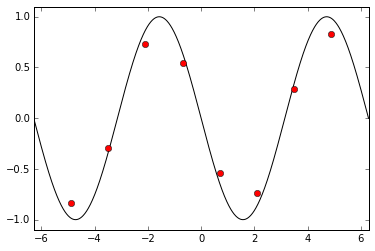

In [9]:
f = lambda x: numpy.sin(x)
f_dubl_prime = lambda x: -numpy.sin(x)

# Use uniform discretization
x = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, 1000)
N = 10
x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N)
delta_x = x_hat[1] - x_hat[0]

# Compute derivative
f_dubl_prime_hat = numpy.empty(x_hat.shape)
f_dubl_prime_hat[1:-1] = (f(x_hat[2:]) -2.0 * f(x_hat[1:-1]) + f(x_hat[:-2])) / (delta_x**2)

# Use first-order differences for points at edge of domain
f_dubl_prime_hat[0] = (2.0 * f(x_hat[0]) - 5.0 * f(x_hat[1]) + 4.0 * f(x_hat[2]) - f(x_hat[3])) / delta_x**2
f_dubl_prime_hat[-1] = (2.0 * f(x_hat[-1]) - 5.0 * f(x_hat[-2]) + 4.0 * f(x_hat[-3]) - f(x_hat[-4])) / delta_x**2

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, f_dubl_prime(x), 'k')
axes.plot(x_hat, f_dubl_prime_hat, 'ro')
axes.set_xlim((x[0], x[-1]))
axes.set_ylim((-1.1, 1.1))

plt.show()

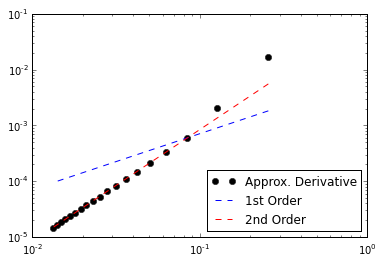

In [13]:
f = lambda x: numpy.sin(x)
f_dubl_prime = lambda x: -numpy.sin(x)

# Compute the error as a function of delta_x
delta_x = []
error = []
# for N in xrange(2, 101):
for N in xrange(50, 1000, 50):
    x_hat = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, N)
    delta_x.append(x_hat[1] - x_hat[0])

    # Compute derivative
    f_dubl_prime_hat = numpy.empty(x_hat.shape)
    f_dubl_prime_hat[1:-1] = (f(x_hat[2:]) -2.0 * f(x_hat[1:-1]) + f(x_hat[:-2])) / (delta_x[-1]**2)

    # Use second-order differences for points at edge of domain
    f_dubl_prime_hat[0] = (2.0 * f(x_hat[0]) - 5.0 * f(x_hat[1]) + 4.0 * f(x_hat[2]) - f(x_hat[3])) / delta_x[-1]**2
    f_dubl_prime_hat[-1] = (2.0 * f(x_hat[-1]) - 5.0 * f(x_hat[-2]) + 4.0 * f(x_hat[-3]) - f(x_hat[-4])) / delta_x[-1]**2
    
    error.append(numpy.linalg.norm(numpy.abs(f_dubl_prime(x_hat) - f_dubl_prime_hat), ord=numpy.infty))
    
error = numpy.array(error)
delta_x = numpy.array(delta_x)
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

# axes.plot(delta_x, error)
axes.loglog(delta_x, error, "ko", label="Approx. Derivative")
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[2], error[2], 1.0) * delta_x**1.0, 'b--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[2], error[2], 2.0) * delta_x**2.0, 'r--', label="2nd Order")
axes.legend(loc=4)

plt.show()